In [207]:
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""

test_run = True
save_dir = "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/"
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

    
dataset_list = ['flan_v2', 'tulu_v1_human_mix', 'tulu_v2_human_mix']
sort_by_list = [
     # kmeans
#     'kmeansl2_nc=300', 'kmeansl2_nc=1000', 'kmeansl2_nc=3000',
#     'prob',
#     'dppmap_k=Kcos', 'dppmap_k=Kcosp', 'dppmap_k=Kcos1np', 
]

options_list = itertools.product(dataset_list, sort_by_list)

    
for dataset, sort_by in options_list:
    cmd = f"""
     python note_explore_data_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=32,
        cpu_mem=128,
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    if not test_run:
        print(out)




Submiting job with:
{
    "job_name": "prune.flan_v2.dppmap_k=Kcos",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=prune.flan_v2.dppmap_k=Kcos --partition=el8 --nodes=1 --ntasks-per-node=1 --cpus-per-task=32 --mem=128GB --gres=gpu:1 --output=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/%J.out --time=6:00:00 /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/tmpktaadr3r', 'job_id': 964446}]

Submiting job with:
{
    "job_name": "prune.flan_v2.dppmap_k=Kcosp",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
[{'args': 'sbatch --job-name=prune.flan_v2.dppmap_k=Kcosp --partition=el8 --nodes=1 --ntasks-per-node=1 --cpus-per-task=32 --mem=128GB --gres=gpu:1 --output=/gpfs/u/s

In [215]:
from datasets import load_dataset



train_file = '../data/processed/tulu/tulu_v1_human_mix.jsonl'
data_files = {'train': train_file}
raw_datasets = load_dataset("json", data_files=data_files)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-5cdb06cb4d153d02/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [222]:
train_file = '../data/processed/tulu/tulu_v1_human_mix.jsonl'



'tulu_v1_human_mix'

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [128]:
import os
import sys
import numpy as np
import time
import re

import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers

from note_explore_data_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_l2_to_prototypes,
    sort_dpp_map,)

In [129]:
test_run = True
dataset = 'tulu_v1_human_mix'

# sort_by = 'kmeansl2_nc=100'
# sort_by = 'prob'
sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'

save_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b/{dataset}/'
os.makedirs(save_dir, exist_ok=True)

lm_output_dir = "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/llama-7b_outputs/"

In [130]:

save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
# some entries are nan, impute with mean value.
d['log_probs'] = np.nan_to_num(d['log_probs'], nan=np.nanmean(d['log_probs']))
text_embeddings = d['text_embeddings']
log_probs = d['log_probs'].squeeze()

if test_run:
    text_embeddings = text_embeddings[:1000]
    log_probs = log_probs[:1000]


In [131]:


if sort_by.startswith('kmeansl2'):
    match = re.search(r'(?<=\=)\d+', sort_by)
    n_clusters = int(match.group()) if match else None
    S = sort_kmeans_l2_to_prototypes(text_embeddings, n_clusters)
elif sort_by == 'prob':
    S = log_probs
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None  
    inds = sort_dpp_map(text_embeddings, log_probs, kernel_type=kernel_type)

if not test_run:
    if sort_by.startswith('dpp'):
        save_to_pickle(
            save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
            output={'inds': inds})
    else:
        save_sorted_inds(save_dir, S, sort_by, reverse=False)
        save_sorted_inds(save_dir, S, sort_by, reverse=True)


fast_map_dpp iterations =  100
fast_map_dpp iterations =  200
fast_map_dpp iterations =  300
fast_map_dpp iterations =  400
fast_map_dpp iterations =  500
fast_map_dpp iterations =  600
fast_map_dpp iterations =  700
fast_map_dpp iterations =  800
fast_map_dpp iterations =  900


In [202]:
X = text_embeddings
logP = log_probs
kernel_type = 'Kcos1np'




fast_map_dpp iterations =  100
fast_map_dpp iterations =  200
fast_map_dpp iterations =  300
fast_map_dpp iterations =  400
fast_map_dpp iterations =  500
fast_map_dpp iterations =  600
fast_map_dpp iterations =  700
fast_map_dpp iterations =  800
fast_map_dpp iterations =  900


In [203]:
inds2 = sort_dpp_map(text_embeddings, log_probs, kernel_type=kernel_type)

fast_map_dpp iterations =  100
fast_map_dpp iterations =  200
fast_map_dpp iterations =  300
fast_map_dpp iterations =  400
fast_map_dpp iterations =  500
fast_map_dpp iterations =  600
fast_map_dpp iterations =  700
fast_map_dpp iterations =  800
fast_map_dpp iterations =  900


In [204]:
np.array(inds)-np.array(inds2)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [188]:
np.sum(X*X, axis=-1)

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [205]:
k = 200

len(set(inds[:k]).intersection(set(inds2[:k])))


200

In [193]:
inds[:5], inds2[:5]

([9, 650, 567, 108, 292], [87, 431, 567, 86, 982])

In [155]:
kernel_type = 'Kcos'
# kernel_type = 'Kcosp'

jitter = -100000

def kernel_matrix_ith_row(i):
    """Returns i-th row of kernel matrix `K`"""
    if kernel_type == 'Kcos':
        Ki = X[i]@X.T
    elif kernel_type == 'Kcosp':
        Ki = P[i]*X[i]@X.T*P
    elif kernel_type == 'Kcos1np':
        Ki = (1-P[i])*X[i]@X.T*(1-P)
    else:
        raise ValueError(f'kernel_type={kernel_type} not supported')
    Ki[i] += jitter
    return Ki

np.vstack([kernel_matrix_ith_row(i) for i in range(3)])



array([[-99995,     14,     23],
       [    14, -99950,     86],
       [    23,     86, -99851]])

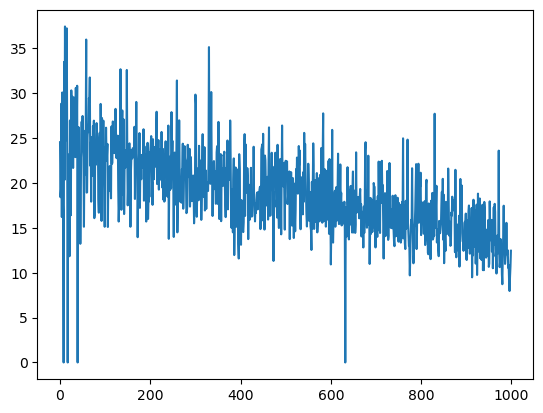

In [132]:
plt.plot(S[inds])

array([ True,  True,  True, ...,  True,  True,  True])